# Arguments Against the Implementation Invariance of PA and PGIG

In our [paper](https://arxiv.org/abs/2007.10685) we left the question of whether or not PGIG is implementation invariant to future work.

In this notebook we present arguments against the implementation invariance of PA and PGIG. 

## Counter Example: Sketch

The proof (by counter example) goes as follows. We construct two functionally equivalent networks which share weights in their first layers but still have different positive regimes, due to different biases. Since the $a_{+}$ pattern used for PatternAttribution in [the original paper](https://arxiv.org/abs/1705.05598) is a function of the positive regime, different patterns emerge for the shared weights. The different patterns then lead to different attributions (explanations) for identical inputs (into the two functionally equivalent networks) and thus PA and PGIG should not be implementation invariant. 

We consider the two networks 

$f'(\mathbf{x}) = ReLU(\mathcal{I}_{1}ReLU(\mathbf{w}^{T}\mathbf{x} - 0) - b)$

and 

$f''(\mathbf{x}) = ReLU(\mathbf{w}^{T}\mathbf{x} - b)$

where $\mathcal{I}_{1}=1$ is the identity matrix. The networks are functionally equivalent for $b>0$ but subtract the non-zero bias in different layers. The networks are very similar to the ones used in the [IG paper](https://arxiv.org/abs/1703.01365), in which they are also used in the context of implementation invariance.

In what follows we fix weights and biases, generate data, compute patterns, modify the weights with the patterns and propagate back modified gradients, which yield the attributions according to PA. 

Let us set 

$w=(1,2)^{T}, b=1$ and refer to the first network as the network 1 and the second as network 2. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from typing import Tuple
np.random.seed(42)
import seaborn as sns

## Pattern Computation
We copy the pattern functions from previous notebooks.

In [2]:
def positive_regime(input: np.array, output: np.array, feature_in: int, feature_out: int) -> Tuple[np.array, np.array]:
    """
    Filter the positive regime. 
    
    Args:
        input: Input array of shape (N, features_in).
        output: Output array of shape (N, features_out).
        feature_in: Input feature dimension to consider with 0 <= feature_in <= dim_in.
        feature_out: Output feature dimension to consider with

    Returns: Filtered input array of shape (N-M, 1) and corresponding output array of shape (N-M, 1),
    where M is the number of negative outputs.
    """

    # Collect input and output features at positions feature_in and feature_out, respectively.
    features_in = input[:, feature_in]
    features_out = output[:, feature_out]

    # Collect inputs and corresponding outputs where feature_out > 0
    x_plus = []
    y_plus = []

    for idx, feature_out in enumerate(features_out):
        if feature_out > 0:
            x_plus.append(features_in[idx])
            y_plus.append(features_out[idx])
            
    return np.array(x_plus), np.array(y_plus)

def patterns(input: np.array, output: np.array, weights: np.array) -> np.array:
    """
    The pattern estimation according to Eq. 7 (Kindermans et al., 2017) for the positive regime.  

    Args:
        input: Input to the model of shape (N, features_in).
        output: ReLU activated output of the model of shape (N, features_out).
        weights: Weights of the model of shape (features_in, features_out).


    Returns: The pattern estimation (a+) of shape (features_in, features_out).

    """

    # Create three matrices E[x+ y], E[x+].
    E_x_plus_matrix = np.zeros_like(weights, dtype=np.double) 
    E_x_plus_times_y_matrix = np.zeros_like(weights, dtype=np.double)

    # Populate the matrices above.
    dims_in, dims_out = weights.shape
    for dim_in in range(dims_in):
        for dim_out in range(dims_out):
            # Collect all x,y for which ReLU(wTx) = y > 0
            x_plus, y_plus = positive_regime(input=input,
                                             output=output,
                                             feature_in=dim_in,
                                             feature_out=dim_out)

            # Create the expected values, aka means.
            E_x = np.mean(x_plus)
            E_x_y = np.mean(x_plus * y_plus)

            # Populate the matrices above.
            E_x_plus_matrix[dim_in][dim_out] = E_x 
            E_x_plus_times_y_matrix[dim_in][dim_out] = E_x_y 

    E_y = np.mean(output) 
    E_y_matrix = np.full_like(weights, E_y, dtype=np.double)

    # Compute the nominator and denominator according to Eq. 7.
    nominator = E_x_plus_times_y_matrix - (E_x_plus_matrix * E_y_matrix)
    denominator = np.matmul(weights.T, E_x_plus_times_y_matrix) - np.matmul(weights.T, (E_x_plus_matrix * E_y_matrix))
    pattern = nominator / denominator

    return pattern

## Data
We are considering a bivariate distribution. $x1$ is sampled from a normal distribution. $x2 = x1k$, where $k$ is sampled from a Rademacher distribution.
See [Wikipedia](https://en.wikipedia.org/wiki/Normally_distributed_and_uncorrelated_does_not_imply_independent).

In [3]:
size = 5000 # number of samples to work with
mean = 0.0
std_dev = 0.7 # change this to change pattern differences btw network 1 and network 2. 


x1 = np.random.normal(size=size, loc=mean, scale=std_dev) # loc = 0, scale = 1 if not overwritten 
rand = np.random.choice(a=[False, True], size=size, p=[.5, .5])  # Rademacher distribution 
x2 = []
for x, r in zip(list(x1), list(rand)):
    if r:
        x2.append(x)
    else:
        x2.append(-x)

ipt = np.array([np.array([_x1, _x2]) for _x1, _x2 in zip(x1, x2)]) # original input 

w1 = 1.
w2 = 2.
wgt = np.array([[w1], [w2]]) # shared weights

wgt_n1_l2 = np.array([[1.0]]) # weights of the second layer of network 1

opt_n1_l1 = [np.matmul(wgt.T, i) for i in ipt] # the output of the 1st layer of network 1 (w/ zero bias)
opt_n1_l1 = np.array(opt_n1_l1)

ipt_n1_l2 = np.array([max(np.array([0]), o) for o in opt_n1_l1]) # ReLU activate the output of the 1st layer
opt_n1_l2 = np.array([i-1 for i in ipt_n1_l2]) # substract unit bias, which yields the output of the 2nd layer

opt_n2_l1 = [o - 1 for o in opt_n1_l1] # the output of the 1st layer with of network 2 (w/ unit bias)
opt_n2_l1 = np.array(opt_n2_l1)

## Patterns
In what follows we compute patterns for all layers.

In [4]:
patterns_network_one_layer_one = patterns(input=ipt, output=opt_n1_l1, weights=wgt)
patterns_network_one_layer_two = patterns(input=ipt_n1_l2, output=opt_n1_l2, weights=wgt_n1_l2)
patterns_network_two_layer_one = patterns(input=ipt, output=opt_n2_l1, weights=wgt)
print(f'Patterns of network 1 layer 1 w/ zero bias:\n {patterns_network_one_layer_one}')
print(f'Patterns of network 1 layer 2 w/ unit bias:\n {patterns_network_one_layer_two}')
print(f'Patterns of network 2 layer 1 w/ unit bias:\n {patterns_network_two_layer_one}')

Patterns of network 1 layer 1 w/ zero bias:
 [[0.20428254]
 [0.39785873]]
Patterns of network 1 layer 2 w/ unit bias:
 [[1.]]
Patterns of network 2 layer 1 w/ unit bias:
 [[0.26148377]
 [0.36925811]]


## Attributions 
In what follows we will compute attributions for both networks. 

We will consider an input that exists in all positive regimes, namely $x = (3,3)^{T}$. 

In [5]:
x = np.array([3.0, 3.0])

### Network 1

In [6]:
# forward pass 
y_n1 = np.matmul(wgt.T, x) # first layer 
assert y_n1 > 0, 'ReLU should not filter in this experiment'
y_n1 = y_n1 - 1 # second layer 
assert y_n1 > 0, 'ReLU should not filter in this experiment'

# modify weights prior to backward pass 
wgt_p_n1_l1 = wgt * patterns_network_one_layer_one
wgt_p_n1_l2 = wgt_n1_l2 * patterns_network_one_layer_two 

# backward pass
grad_n1 = y_n1 # PA starts backpropagation w/ y
grad_n1 = wgt_p_n1_l2 * grad_n1 # 2nd relu does not filter (see assertions), multiply w/ mod. weights  
attributions_n1 = wgt_p_n1_l1  * grad_n1 # 1st relu does not filter (see assertions), multiply w/ mod. weights
print(f'PatternAttribution Network 1:\n {attributions_n1}')

PatternAttribution Network 1:
 [[1.6342603]
 [6.3657397]]


### Network 2

In [7]:
# forward pass 
y_n2 = np.matmul(wgt.T, x) - 1
assert y_n2 > 0, 'ReLU should not filter in this experiment'
assert y_n2 == y_n1, 'Networks should be functionally equivalent'

# modify weights prior to backward pass 
wgt_p_n2_l1 = wgt * patterns_network_two_layer_one

# backward pass 
grad_n2 = y_n2 # PA starts backprop with y
attributions_n2 = wgt_p_n2_l1 * grad_n2 # relu does not filter (see assertion above), multiply w/ mod. weights
print(f'PatternAttribution Network 2:\n {attributions_n2}')

PatternAttribution Network 2:
 [[2.09187018]
 [5.90812982]]


## Visualization

Below, the explanations for $x$ are visualized in form of heatmaps.

<AxesSubplot:>

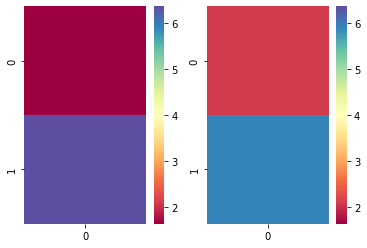

In [8]:
vmin = min(np.min(attributions_n1), np.min(attributions_n2))
vmax = max(np.max(attributions_n1), np.max(attributions_n2))
fig, (ax1, ax2) = plt.subplots(1,2)
sns.heatmap(attributions_n1, vmin=vmin, vmax=vmax, cmap="Spectral", ax=ax1)
sns.heatmap(attributions_n2, vmin=vmin, vmax=vmax,  cmap="Spectral", ax=ax2)

## Conclusion
We receive two different explanations for identical inputs into functionally equivalent networks and thus PA and PGIG are not implementation invariant.